$$\text{TALLER BOOSTING Y MODELOS BASADOS EN ÁRBOLES}$$

Julián Echeverry

MINE 009

*Tópicos Minería de Datos*

**CONTEXTO DEL PROBLEMA DE NEGOCIO - HTML**

`ejercicio_clase 1_intencion compra.html`

Eres el nuevo Analista de Inteligencia de Negocios en una prometedora plataforma de e-commerce. Tu primer gran proyecto es analizar el comportamiento de los usuarios en el sitio web para entender qué factores llevan a una compra.

La gerencia no solo quiere saber *qué* pasó, sino *qué es probable que pase*. Sin embargo, los datos están crudos. Tienes un único log con *todos* los clicks (`e-shop clothing 2008.csv`). No existe un archivo de "compras" separado.

**DESCRIPCIÓN DE ARCHIVO CSV**

- El archivo contiene el *historial de clicks* por sesión de usuario entre los meses de abril y agosto del año 2008.
- Cada fila corresponde a un click.
- Cada sesión tiene un ID único.
- Diccionario de variables:

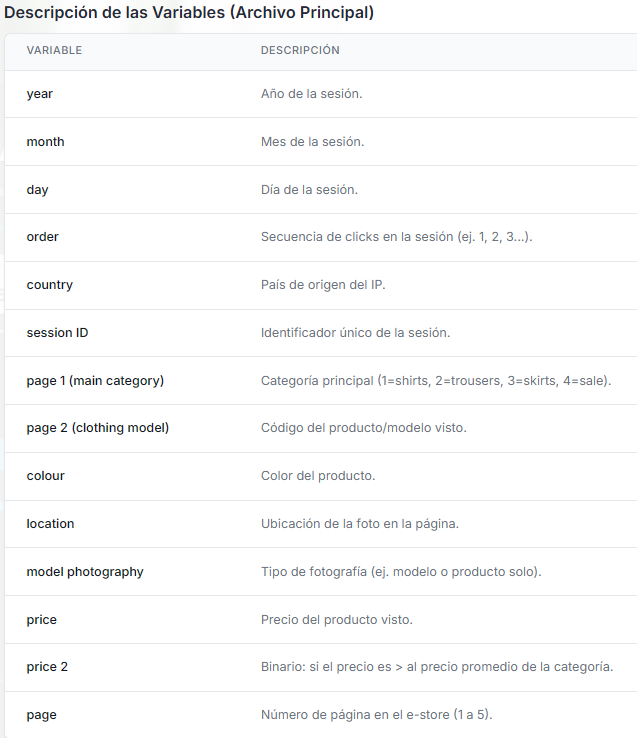

**DEFINICIÓN DE VARIABLE OBJETIVO:**

* La Gerencia quiere identificar a los "buscadores de ofertas". Por lo tanto, definimos una "conversión" como una sesión que visita la página de **Ofertas (Sale)**.

**Orden del cuaderno:**

> 1. Importar librerías

> 2. Exploración de datos originales y transformación

> 3. declaración de pipelines

> 4. división de datos

> 5. Modelo regresión logística

> 6. Modelo random forest

> 7. Modelo XGBoost

> 8. Modelo LightGBM

> 9. Comparación entre modelos

> 10. Importancia de variables

> 11. Recomendaciones de negocio

# 1. Importación de librerías

Se importan librerías de manipulación y visualización de datos, generación de pipelines, y entrenamiento de modelos.

In [ ]:
# Módulos para manipulación de datos y visualización
import pandas as pd
import numpy as np
import io # Usado para cargar datos de ejemplo desde un string
import matplotlib.pyplot as plt
import seaborn as sns
import tabulate

# Preprocesamiento y Pipelines
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Métricas
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import precision_score, recall_score

# Configuraciones generales para el cuaderno
sns.set_style('whitegrid') #Estilo de gráficos seaborn
pd.set_option('display.max_columns', None) # Mostrar todas las columnas de un DataFrame

# 2. Exploración de datos originales y transformación

## 2.1. Exploración del conjunto de datos original

In [2]:
dfclicks = pd.read_csv('../data/e-shop clothing 2008.csv', sep=";")
dfclicks.head()

,year,month,day,order,country,session ID,page 1 (main category),page 2 (clothing model),colour,location,model photography,price,price 2,page
0,2008,4,1,1,29,1,1,A13,1,5,1,28,2,1
1,2008,4,1,2,29,1,1,A16,1,6,1,33,2,1
2,2008,4,1,3,29,1,2,B4,10,2,1,52,1,1
3,2008,4,1,4,29,1,2,B17,6,6,2,38,2,1
4,2008,4,1,5,29,1,2,B8,4,3,2,52,1,1


In [3]:
dfclicks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165474 entries, 0 to 165473
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   year                     165474 non-null  int64 
 1   month                    165474 non-null  int64 
 2   day                      165474 non-null  int64 
 3   order                    165474 non-null  int64 
 4   country                  165474 non-null  int64 
 5   session ID               165474 non-null  int64 
 6   page 1 (main category)   165474 non-null  int64 
 7   page 2 (clothing model)  165474 non-null  object
 8   colour                   165474 non-null  int64 
 9   location                 165474 non-null  int64 
 10  model photography        165474 non-null  int64 
 11  price                    165474 non-null  int64 
 12  price 2                  165474 non-null  int64 
 13  page                     165474 non-null  int64 
dtypes: int64(13), object

> Se encuentra que **el conjunto de datos no tiene datos vacíos**

Generación de variables descriptivas, según el diccionario de datos:

* Nombre de las páginas principales que puede visitar cada usuario:

In [4]:
# page_1_descripcion
dfclicks['page_1_descripcion'] = dfclicks['page 1 (main category)'].map({1: '1-trousers', 
                                                                         2: '2-skirts',
                                                                         3: '3-blouses',
                                                                         4: '4-sale'})

* Color de las prendas/productos:

In [5]:
# colour_descripcion
dfclicks['colour_descripcion'] = dfclicks['colour'].map({1: 'beige' ,
                                                        2: 'black' ,
                                                        3: 'blue' ,
                                                        4: 'brown' ,
                                                        5: 'burgundy' ,
                                                        6: 'gray' ,
                                                        7: 'green' ,
                                                        8: 'navy blue' ,
                                                        9: 'of many colors' ,
                                                        10: 'olive' ,
                                                        11: 'pink' ,
                                                        12: 'red' ,
                                                        13: 'violet' ,
                                                        14: 'white'})

* Indicativo de la presencia de una modelo en la fotografía del producto:

In [6]:
# Model_photography_descripcion
dfclicks['model_photography_descripcion'] = dfclicks['model photography'].map({1: 'yes' ,
                                                                                2: 'no'})

* Nombre del país desde el que se registra la sesión de usuario:

In [7]:
# nombre_pais
dfclicks['nombre_pais'] = dfclicks['country'].map({1: 'Australia' ,
                                                    2: 'Austria' ,
                                                    3: 'Belgium' ,
                                                    4: 'British Virgin Islands' ,
                                                    5: 'Cayman Islands' ,
                                                    6: 'Christmas Island' ,
                                                    7: 'Croatia' ,
                                                    8: 'Cyprus' ,
                                                    9: 'Czech Republic' ,
                                                    10: 'Denmark' ,
                                                    11: 'Estonia' ,
                                                    12: 'unidentified' ,
                                                    13: 'Faroe Islands' ,
                                                    14: 'Finland' ,
                                                    15: 'France' ,
                                                    16: 'Germany' ,
                                                    17: 'Greece' ,
                                                    18: 'Hungary' ,
                                                    19: 'Iceland' ,
                                                    20: 'India' ,
                                                    21: 'Ireland' ,
                                                    22: 'Italy' ,
                                                    23: 'Latvia' ,
                                                    24: 'Lithuania' ,
                                                    25: 'Luxembourg' ,
                                                    26: 'Mexico' ,
                                                    27: 'Netherlands' ,
                                                    28: 'Norway' ,
                                                    29: 'Poland' ,
                                                    30: 'Portugal' ,
                                                    31: 'Romania' ,
                                                    32: 'Russia' ,
                                                    33: 'San Marino' ,
                                                    34: 'Slovakia' ,
                                                    35: 'Slovenia' ,
                                                    36: 'Spain' ,
                                                    37: 'Sweden' ,
                                                    38: 'Switzerland' ,
                                                    39: 'Ukraine' ,
                                                    40: 'United Arab Emirates' ,
                                                    41: 'United Kingdom' ,
                                                    42: 'USA' ,
                                                    43: 'biz (*.biz)' ,
                                                    44: 'com (*.com)' ,
                                                    45: 'int (*.int)' ,
                                                    46: 'net (*.net)' ,
                                                    47: 'org (*.org)'})

* Ubicación de la foto en la página del producto:

In [8]:
# photo_location_descripcion
dfclicks['photo_location'] = dfclicks['location'].map({1: 'top left' ,
                                                        2: 'top in the middle' ,
                                                        3: 'top right' ,
                                                        4: 'bottom left' ,
                                                        5: 'bottom in the middle' ,
                                                        6: 'bottom right'})

* Indicativo de si el precio es mayor al precio promedio de la categoría:

In [9]:
# Price2_descripcion
dfclicks['price2_descripcion'] = dfclicks['price 2'].map({1: 'yes' ,
                                                            2: 'no'})

In [10]:
# Comprobación
dfclicks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165474 entries, 0 to 165473
Data columns (total 20 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   year                           165474 non-null  int64 
 1   month                          165474 non-null  int64 
 2   day                            165474 non-null  int64 
 3   order                          165474 non-null  int64 
 4   country                        165474 non-null  int64 
 5   session ID                     165474 non-null  int64 
 6   page 1 (main category)         165474 non-null  int64 
 7   page 2 (clothing model)        165474 non-null  object
 8   colour                         165474 non-null  int64 
 9   location                       165474 non-null  int64 
 10  model photography              165474 non-null  int64 
 11  price                          165474 non-null  int64 
 12  price 2                        165474 non-nu

In [11]:
# Comprobación
dfclicks.head()

,year,month,day,order,country,session ID,page 1 (main category),page 2 (clothing model),colour,location,model photography,price,price 2,page,page_1_descripcion,colour_descripcion,model_photography_descripcion,nombre_pais,photo_location,price2_descripcion
0,2008,4,1,1,29,1,1,A13,1,5,1,28,2,1,1-trousers,beige,yes,Poland,bottom in the middle,no
1,2008,4,1,2,29,1,1,A16,1,6,1,33,2,1,1-trousers,beige,yes,Poland,bottom right,no
2,2008,4,1,3,29,1,2,B4,10,2,1,52,1,1,2-skirts,olive,yes,Poland,top in the middle,yes
3,2008,4,1,4,29,1,2,B17,6,6,2,38,2,1,2-skirts,gray,no,Poland,bottom right,no
4,2008,4,1,5,29,1,2,B8,4,3,2,52,1,1,2-skirts,brown,no,Poland,top right,yes


De momento no se harán cambios a los tipos de variables del dataframe `dfclicks`, dado que las variables numéricas que corresponden a categorías tienen su respectiva variable categórica análoga indicando la descripción.

Por otra parte, no se hará ninguna modelación al nivel de agregación `clicks`, si no al nivel de agregación por `session ID`.

## 2.2. Creación variable objetivo (target)

Pero antes, debemos crear el dataframe `dfpaginas` 👇👇, a nivel de sesión de usuario. Usaremos el método `pivot_table` que permite obtener diferentes tipos de agregación de variables.

Este dataframe va a contener el ***conteo de clicks de cada sesión en los tipos de página principal***:

In [12]:
dfpaginas = dfclicks.pivot_table(index = 'session ID', 
                                  columns= ['page_1_descripcion'], 
                                  values= 'order', 
                                  aggfunc='count').reset_index()

In [13]:
dfpaginas.fillna(0, inplace=True)

* Para mejor legibilidad, se ajustan los nombres de las columnas:

In [14]:
dfpaginas.rename(columns={'1-trousers': 'visitaspag1trousers',
                          '2-skirts': 'visitaspag2skirts',
                          '3-blouses': 'visitaspag3blouses',
                          '4-sale': 'visitaspag4sales',
                          }, inplace = True)

In [15]:
dfpaginas

page_1_descripcion,session ID,visitaspag1trousers,visitaspag2skirts,visitaspag3blouses,visitaspag4sales
0,1,2.0,3.0,2.0,2.0
1,2,2.0,5.0,0.0,3.0
2,3,0.0,1.0,4.0,1.0
3,4,2.0,0.0,2.0,0.0
4,5,0.0,0.0,1.0,0.0
...,...,...,...,...,...
24021,24022,3.0,0.0,0.0,0.0
24022,24023,4.0,0.0,0.0,3.0
24023,24024,0.0,1.0,0.0,0.0
24024,24025,1.0,0.0,0.0,0.0


In [16]:
dfpaginas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24026 entries, 0 to 24025
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   session ID           24026 non-null  int64  
 1   visitaspag1trousers  24026 non-null  float64
 2   visitaspag2skirts    24026 non-null  float64
 3   visitaspag3blouses   24026 non-null  float64
 4   visitaspag4sales     24026 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 938.6 KB


Definimos la variable objetivo `target` con los valores:

- 1: Si la sesión mostró al menos una visita a la página `4-sale` >= 1
- 0: Si la sesión no mostró ninguna una visita a la página `4-sale` = 0

In [17]:
dfpaginas["target"] = np.where(dfpaginas['visitaspag4sales'] >= 1, 1, 0)
dfpaginas.head()

page_1_descripcion,session ID,visitaspag1trousers,visitaspag2skirts,visitaspag3blouses,visitaspag4sales,target
0,1,2.0,3.0,2.0,2.0,1
1,2,2.0,5.0,0.0,3.0,1
2,3,0.0,1.0,4.0,1.0,1
3,4,2.0,0.0,2.0,0.0,0
4,5,0.0,0.0,1.0,0.0,0


## 2.3. Creación dataset de trabajo agregado por sesiones

Además de obtener la variable objetivo a nivel de sesión de usuario, se necesitan obtener las variables explicativas.

Sin embargo, las agregaciones deben excluir las visitas a la página de ofertas, para evitar correlaciones entre variables explicativas y variable objetivo 👇👇:

In [18]:
# Creación de la copia del DataFrame original para posterior filtrado
dfclicks_copia = dfclicks.copy()

In [19]:
# Filtrado del DataFrame para incluir solo las filas donde 'page 1 (main category)' es 1, 2 o 3
dfclicks_copia_filtro123 = dfclicks_copia[dfclicks_copia['page 1 (main category)'].isin([1,2,3])]

In [20]:
dfclicks_copia_filtro123["page_1_descripcion"].unique()

array(['1-trousers', '2-skirts', '3-blouses'], dtype=object)

* El método `pivot_table` permite realizar diferentes tipos de agregación para las variables ingresadas:

In [21]:
#dfsesiones
dfsesiones = dfclicks_copia_filtro123.pivot_table(index = 'session ID', 
                                                    # columns= ['page_1_descripcion'], 
                                                    values= ['order', 'price', 'nombre_pais', 'page 2 (clothing model)', 'page_1_descripcion'] ,
                                                    aggfunc={'order': 'count',
                                                            'price': ['max', 'mean'],
                                                            'nombre_pais': 'first',
                                                            'page 2 (clothing model)': 'nunique',
                                                            'page_1_descripcion': lambda x: x.mode()[0]
                                                            }).reset_index()

In [22]:
dfsesiones.head()

session ID     nombre_pais order page 2 (clothing model) page_1_descripcion  \
                       first count                 nunique           <lambda>   
0          1          Poland     7                       7           2-skirts   
1          2          Poland     7                       5           2-skirts   
2          3         Ireland     5                       5          3-blouses   
3          4         Ireland     4                       4         1-trousers   
4          5  Czech Republic     1                       1          3-blouses   

  price             
    max       mean  
0    57  41.857143  
1    67  53.000000  
2    48  42.000000  
3    62  45.250000  
4    57  57.000000

In [23]:
# convertimos las columnas a sólo un nivel:

dfsesiones.columns = ['{}_{}'.format(a, b) for a, b in dfsesiones.columns]


In [24]:
dfsesiones.rename(columns={'session ID_': 'session_ID'}, inplace=True)

In [25]:
dfsesiones.head()

,session_ID,nombre_pais_first,order_count,page 2 (clothing model)_nunique,page_1_descripcion_<lambda>,price_max,price_mean
0,1,Poland,7,7,2-skirts,57,41.857143
1,2,Poland,7,5,2-skirts,67,53.000000
2,3,Ireland,5,5,3-blouses,48,42.000000
3,4,Ireland,4,4,1-trousers,62,45.250000
4,5,Czech Republic,1,1,3-blouses,57,57.000000


* Para mejor legibilidad, se cambian los nombres de las variables que contienen las agregaciones:

In [26]:
dfsesiones.rename(columns={
                            'nombre_pais_first': 'pais',
                            'order_count': 'num_visitas',
                            'price_max': 'precio_maximo',
                            'price_mean': 'precio_promedio',
                            'page 2 (clothing model)_nunique': 'numero_modelos',
                            'page_1_descripcion_<lambda>': 'pagina_mas_visitada'
}, inplace=True)

In [27]:
dfsesiones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22284 entries, 0 to 22283
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   session_ID           22284 non-null  int64  
 1   pais                 22284 non-null  object 
 2   num_visitas          22284 non-null  int64  
 3   numero_modelos       22284 non-null  int64  
 4   pagina_mas_visitada  22284 non-null  object 
 5   precio_maximo        22284 non-null  int64  
 6   precio_promedio      22284 non-null  float64
dtypes: float64(1), int64(4), object(2)
memory usage: 1.2+ MB


## 2.4. Unión datasets

* Con un `merge` entre `dfsesiones` y ``dfpaginas``, se configura el dataframe con que se entrenarán los modelos `dftrabajo` 👇👇.

In [28]:
#merge de los dos dataframes
dftrabajo = pd.merge(dfsesiones, dfpaginas, left_on='session_ID', right_on='session ID', how='left')

* Se eliminan los IDs para que no sean tomados como variables explicativas:

In [29]:
dftrabajo = dftrabajo.drop(columns=['session ID', 'session_ID'])

In [30]:
dftrabajo.head()

,pais,num_visitas,numero_modelos,pagina_mas_visitada,precio_maximo,precio_promedio,visitaspag1trousers,visitaspag2skirts,visitaspag3blouses,visitaspag4sales,target
0,Poland,7,7,2-skirts,57,41.857143,2.0,3.0,2.0,2.0,1
1,Poland,7,5,2-skirts,67,53.000000,2.0,5.0,0.0,3.0,1
2,Ireland,5,5,3-blouses,48,42.000000,0.0,1.0,4.0,1.0,1
3,Ireland,4,4,1-trousers,62,45.250000,2.0,0.0,2.0,0.0,0
4,Czech Republic,1,1,3-blouses,57,57.000000,0.0,0.0,1.0,0.0,0


In [31]:
dftrabajo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22284 entries, 0 to 22283
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   pais                 22284 non-null  object 
 1   num_visitas          22284 non-null  int64  
 2   numero_modelos       22284 non-null  int64  
 3   pagina_mas_visitada  22284 non-null  object 
 4   precio_maximo        22284 non-null  int64  
 5   precio_promedio      22284 non-null  float64
 6   visitaspag1trousers  22284 non-null  float64
 7   visitaspag2skirts    22284 non-null  float64
 8   visitaspag3blouses   22284 non-null  float64
 9   visitaspag4sales     22284 non-null  float64
 10  target               22284 non-null  int64  
dtypes: float64(5), int64(4), object(2)
memory usage: 1.9+ MB


In [32]:
# Guardamos el dataset final para el modelado
dftrabajo.to_csv('../data/df_trabajo_sesiones.csv', index=False)

In [33]:
# Distribución de la variable objetivo -target- en el dataset final -dftrabajo-
# Determinamos acá si es un problema balanceado o desbalanceado
dftrabajo['target'].value_counts(normalize=True)

target
0    0.665679
1    0.334321
Name: proportion, dtype: float64

Se puede observar que la variable objetivo `target` tiene una proporción de 1's del 33.43% de los registros del dataframe final `dftrabajo`, por lo cual se puede decir que se trata de un problema desbalanceado.

Esto deberá tratarse en el entrenamiento de los modelos con opciones como `is_unbalance` (LightGBM) y `scale_pos_weight` (XGBoost).

# 3. declaración de pipelines

> En primer lugar, se definen las **listas de variables numéricas y categóricas**:

In [34]:
numeric_features = ['num_visitas', 'numero_modelos', 'precio_maximo', 'precio_promedio', 'visitaspag1trousers', 'visitaspag2skirts', 'visitaspag3blouses']

In [35]:
# Seleccionar automáticamente todas las columnas 'object' como categóricas
categorical_features = dftrabajo.select_dtypes(include=['object', 'category']).columns.tolist()

In [36]:
# Asegurarnos de que las numéricas no estén en la lista de categóricas
categorical_features = [col for col in categorical_features if col not in numeric_features and col != 'target' and col != 'visitaspag4sales']

In [37]:
print(f"Features/variables Numéricas: {numeric_features}")
print(f"Features/variables Categóricas: {categorical_features}")

Features/variables Numéricas: ['num_visitas', 'numero_modelos', 'precio_maximo', 'precio_promedio', 'visitaspag1trousers', 'visitaspag2skirts', 'visitaspag3blouses']
Features/variables Categóricas: ['pais', 'pagina_mas_visitada']


> Luego, se declaran los **Transformadores**

* Pipelines por tipo de variable

In [38]:
# Crear el transformador para variables numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Imputar NAs con la mediana
    ('scaler', StandardScaler())                 # Escala los datos.
])

Si bien el escalado de datos no afecta de ninguna manera los modelos basados en árboles, sí es fundamental para los métodos que se basan en cálculos de distancias (regresión logística, KNN, etc).

In [39]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Imputar NAs con la moda
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))   # Aplicar One-Hot Encoding
])

* Asignación de transformadores a las listas con el método/función `ColumnTransformer`

In [40]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Dejar pasar cualquier columna no especificada directamente
)

preprocessor
print("\n\nPreprocesador creado exitosamente!")



Preprocesador creado exitosamente!


# 4. división de datos

Se dividen los datos en:

- Variables explicativas (`X`): Aquí se excluyen las variables `'target'` y `'visitaspag4sales'`
- Variable objetivo (`y`)
- Datos de entrenamiento (`train`): 80% de las filas del dataframe de trabajo.
- Datos de prueba al modelo (`test`): 20% de las filas del dataframe de trabajo.

In [41]:
X = dftrabajo.drop(['target', 'visitaspag4sales'], axis=1)
y = dftrabajo['target']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Tamaño de X Train: {X_train.shape}")
print(f"Tamaño de X Test: {X_test.shape}")

Tamaño de X Train: (17827, 9)
Tamaño de X Test: (4457, 9)


In [43]:
print(f"Tamaño de y Train: {y_train.shape}")
print(f"Tamaño de y Test: {y_test.shape}")

Tamaño de y Train: (17827,)
Tamaño de y Test: (4457,)


# 5. Modelo regresión logística (línea base 1)

Pipeline:

In [44]:
# Crear el Pipeline de Regresión Logística
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(random_state=42, n_jobs=-1)) # n_jobs=-1 usa todos los cores
])

Entrenamiento del modelo:

In [45]:
# Entrenar el pipeline
print("Entrenando el Pipeline de Regresión Logística...")
lr_pipeline.fit(X_train, y_train)
print("Entrenamiento completado.")

Entrenando el Pipeline de Regresión Logística...
Entrenamiento completado.


Evaluación del modelo:

In [46]:
y_pred_lr = lr_pipeline.predict(X_test)

y_prob_lr = lr_pipeline.predict_proba(X_test)[:, 1]

In [47]:
print("\n--- Reporte de Clasificación (Regresión Logística) ---")
print(classification_report(y_test, y_pred_lr))


--- Reporte de Clasificación (Regresión Logística) ---
              precision    recall  f1-score   support

           0       0.71      0.92      0.80      2967
           1       0.62      0.27      0.37      1490

    accuracy                           0.70      4457
   macro avg       0.67      0.59      0.59      4457
weighted avg       0.68      0.70      0.66      4457



In [48]:
# Guardar métricas
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr, pos_label=1)
lr_auc = roc_auc_score(y_test, y_prob_lr)
lr_precision = precision_score(y_test, y_pred_lr, pos_label=1)
lr_recall = recall_score(y_test, y_pred_lr, pos_label=1)

# 6. Modelo random forest (línea base 2)

Pipeline:

In [49]:
# Crear el Pipeline de Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42, n_jobs=-1)) # n_jobs=-1 usa todos los cores
])

Entrenamiento del modelo:

In [50]:
# Entrenar el pipeline
print("Entrenando el Pipeline de Random Forest...")
rf_pipeline.fit(X_train, y_train)
print("Entrenamiento completado.")

Entrenando el Pipeline de Random Forest...
Entrenamiento completado.


Evaluación del modelo:

In [51]:
y_pred_rf = rf_pipeline.predict(X_test)

y_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]

In [52]:
print("\n--- Reporte de Clasificación (Random Forest) ---")
print(classification_report(y_test, y_pred_rf))


--- Reporte de Clasificación (Random Forest) ---
              precision    recall  f1-score   support

           0       0.74      0.82      0.78      2967
           1       0.53      0.42      0.47      1490

    accuracy                           0.68      4457
   macro avg       0.64      0.62      0.62      4457
weighted avg       0.67      0.68      0.67      4457



In [53]:
# Guardar métricas
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf, pos_label=1)
rf_auc = roc_auc_score(y_test, y_prob_rf)
rf_precision = precision_score(y_test, y_pred_rf, pos_label=1)
rf_recall = recall_score(y_test, y_pred_rf, pos_label=1)

# 7. Modelo XGBoost

Pipeline:

In [54]:
# Cálculo de 'scale_pos_weight' para ingresar como parámetro en modelos de boosting
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"Scale Pos Weight: {scale_pos_weight:.2f}")

Scale Pos Weight: 1.99


In [55]:
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(
        random_state=42, 
        use_label_encoder=False, 
        eval_metric='logloss', # Función de pérdida/costo a minimizar
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight # Ayudar con el desbalanceo
    ))
])

Entrenamiento del modelo:

In [56]:
# Entrenar el pipeline
print("Entrenando el Pipeline de XGBoost...")
xgb_pipeline.fit(X_train, y_train)
print("Entrenamiento completado.")

Entrenando el Pipeline de XGBoost...


c:\Users\HP ENVY\AppData\Local\pypoetry\Cache\virtualenvs\ejercicio-clase-boosting-LZc5TFcY-py3.11\Lib\site-packages\xgboost\training.py:199: UserWarning: [23:20:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Entrenamiento completado.


Evaluación del modelo:

In [57]:
y_pred_xgb = xgb_pipeline.predict(X_test)
y_prob_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

In [58]:
print("\n--- Reporte de Clasificación (XGBoost) ---")
print(classification_report(y_test, y_pred_xgb))


--- Reporte de Clasificación (XGBoost) ---
              precision    recall  f1-score   support

           0       0.80      0.67      0.73      2967
           1       0.51      0.67      0.58      1490

    accuracy                           0.67      4457
   macro avg       0.65      0.67      0.65      4457
weighted avg       0.70      0.67      0.68      4457



In [59]:
# Guardar métricas
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_f1 = f1_score(y_test, y_pred_xgb, pos_label=1)
xgb_auc = roc_auc_score(y_test, y_prob_xgb)
xgb_precision = precision_score(y_test, y_pred_xgb, pos_label=1)
xgb_recall = recall_score(y_test, y_pred_xgb, pos_label=1)

# 8. Modelo LightGBM

Pipeline:

In [60]:
lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LGBMClassifier(
        random_state=42,
        n_jobs=-1,
        is_unbalance=True # Forma de LightGBM de manejar desbalanceo
    ))
])

Entrenamiento del modelo:

In [61]:
print("Entrenando el Pipeline de LightGBM...")
lgbm_pipeline.fit(X_train, y_train)
print("Entrenamiento completado.")

Entrenando el Pipeline de LightGBM...
[LightGBM] [Info] Number of positive: 5960, number of negative: 11867
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,002029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 535
[LightGBM] [Info] Number of data points in the train set: 17827, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,334324 -> initscore=-0,688691
[LightGBM] [Info] Start training from score -0,688691
Entrenamiento completado.


Evaluación del modelo:

In [62]:
y_pred_lgbm = lgbm_pipeline.predict(X_test)
y_prob_lgbm = lgbm_pipeline.predict_proba(X_test)[:, 1]

c:\Users\HP ENVY\AppData\Local\pypoetry\Cache\virtualenvs\ejercicio-clase-boosting-LZc5TFcY-py3.11\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\HP ENVY\AppData\Local\pypoetry\Cache\virtualenvs\ejercicio-clase-boosting-LZc5TFcY-py3.11\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [63]:
print("\n--- Reporte de Clasificación (LightGBM) ---")
print(classification_report(y_test, y_pred_lgbm))


--- Reporte de Clasificación (LightGBM) ---
              precision    recall  f1-score   support

           0       0.81      0.66      0.73      2967
           1       0.51      0.70      0.59      1490

    accuracy                           0.67      4457
   macro avg       0.66      0.68      0.66      4457
weighted avg       0.71      0.67      0.68      4457



In [64]:
# Guardar métricas
lgbm_accuracy = accuracy_score(y_test, y_pred_lgbm)
lgbm_f1 = f1_score(y_test, y_pred_lgbm, pos_label=1)
lgbm_auc = roc_auc_score(y_test, y_prob_lgbm)
lgbm_precision = precision_score(y_test, y_pred_lgbm, pos_label=1)
lgbm_recall = recall_score(y_test, y_pred_lgbm, pos_label=1)

# 9. Comparación entre modelos

In [67]:
comparison_data = {
    'Modelo': ['1. Regresión Logística', '2. Random Forest', '3. XGBoost', '4. LightGBM'],
    'Accuracy': [lr_accuracy, rf_accuracy, xgb_accuracy, lgbm_accuracy],
    'F1-Score (Clase 1)': [lr_f1, rf_f1, xgb_f1, lgbm_f1],
    'ROC AUC': [lr_auc, rf_auc, xgb_auc, lgbm_auc],
    'Precision': [lr_precision, rf_precision, xgb_precision, lgbm_precision],
    'Recall': [lr_recall, rf_recall, xgb_recall, lgbm_recall]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.set_index('Modelo')

print("--- Comparación de Rendimiento 'Out-of-the-Box' ---")
print(comparison_df.to_markdown(floatfmt=".4f"))

--- Comparación de Rendimiento 'Out-of-the-Box' ---
| Modelo                 |   Accuracy |   F1-Score (Clase 1) |   ROC AUC |   Precision |   Recall |
|:-----------------------|-----------:|---------------------:|----------:|------------:|---------:|
| 1. Regresión Logística |     0.7000 |               0.3744 |    0.7320 |      0.6182 |   0.2685 |
| 2. Random Forest       |     0.6839 |               0.4685 |    0.7030 |      0.5349 |   0.4168 |
| 3. XGBoost             |     0.6706 |               0.5779 |    0.7378 |      0.5055 |   0.6745 |
| 4. LightGBM            |     0.6749 |               0.5899 |    0.7492 |      0.5100 |   0.6993 |


> **Accuracy**:

Es la métrica que indica la `proporción en que el modelo hace predicciones/clasificaciones correctas, tanto de la clase positiva (target = 1) como de la clase negativa (target = 0)`.

$$Accuracy = \frac{VP + VN}{VP + VN + FP + FN}$$

En la tabla comparativa se puede observar que los valores son prácticamente iguales para los 4 modelos explorados, esto se debe principalmente a que la clase negativa es preponderantemente mayoritaria (problema desbalanceado) y todos los modelos tienden entonces a clasificar en esta categoría.

Por esta razón, no sería adecuado tomar esta métrica como punto de comparación entre los modelos.

> **Precision**:

Es la métrica que mide la calidad de las predicciones de la clase positiva (target = 1). De gran utilidad cuando se requiere penalizar las "falsas alarmas"/falsos positivos. Ej: Incidencia de enfermedades, marcación de correos spam, etc.
Responde a la pregunta: `¿qué proporción de las predicciones de la clase positiva fueron correctas?`

$$Precision = \frac{VP}{VP + FP}$$

Dada la naturaleza del problema de estudio y los valores diferenciados que se observan en la tabla comparativa, sí es adecuado utilizar esta métrica como punto de calificación de los modelos; incluso si el problema está desbalanceado.

El modelo con el mejor puntaje de Precision, es decir, que clasificó mejor las instancias predichas de clase positiva con menos falsos positivos, fue la Regresión Logística con un 61.82%.

> **Recall**:

Es la métrica que mide la sensibilidad del modelo para identificar "positivos reales". Responde a la pregunta: `¿De todas las instancias que eran realmente positivas, ¿cuántas fueron identificadas por el modelo?`

Importante cuando el costo de un Falso Negativo es alto (ej. detección de una enfermedad grave, donde no detectar un caso positivo es crítico).

$$Recall = \frac{VP}{VP + FN}$$

Dada la naturaleza del problema de estudio y los valores diferenciados que se observan en la tabla comparativa, sí es adecuado utilizar esta métrica como punto de calificación de los modelos; incluso si el problema está desbalanceado.

***Compensación (Trade-off) Precision-Recall***: Normalmente, intentar aumentar una métrica hace que la otra disminuya. Se necesita elegir un equilibrio según el problema (ej. para detección de fraude, Recall puede ser más importante que Precision).

El modelo con el mejor puntaje de Recall, es decir, que clasificó mejor las instancias reales de clase positiva con menos falsos negativos, fue el LightGBM con un 69.93%.

> **F1-Score**:

Es la media armónica de la Precision y el Recall. Proporciona un equilibrio entre ambas métricas.

$$F1-Score = 2 * (\frac{Precision * Recall}{Precision + Recall})$$

Al computar las dos métricas que están enfocadas en los resultados de los modelos ``respecto a la clase positiva (target = 1)``, se convierte en la `métrica más adecuada para calificar modelos cuando las clases están desbalanceadas`.

El modelo con el mejor F1-Score, es decir, que tiene mejor desempeño con la clase positiva (target = 1), es el LightGBM con un puntaje de 0.5899.

> **ROC-AUC**:

Corresponde al Área Bajo la Curva ROC (*Area Under the Receiver Operating Characteristic Curve*) y Mide la `capacidad del modelo para distinguir entre clases en diferentes umbrales`.

- Si el valor es cercano a 1, el modelo tiene buena capacidad para separar las clases.
- Si el valor es cercano a 0.5, el modelo no tiene buena capacidad para separar las clases, y aplicar al modelo equivale a adivinar al azar la variable objetivo.

La **ventaja** de esta métrica es que `no se ve afectada por el desbalance de clases`.

Los 4 modelos obtuvieron un puntaje de 0.7, por lo que se puede concluir que todos tienen buena capacidad de discriminación de clases positiva y negativa.

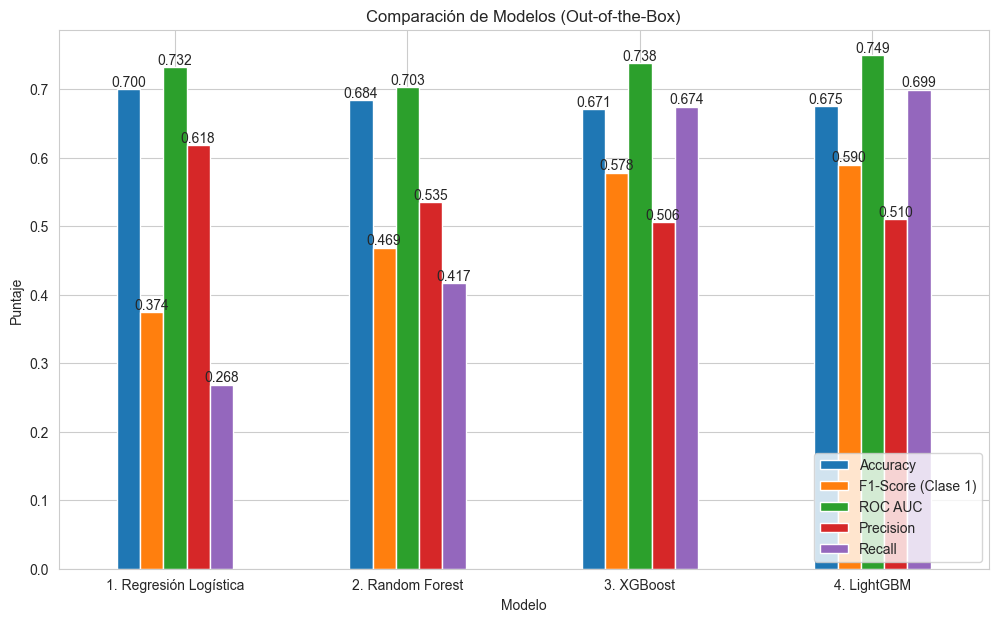

In [68]:
# Graficar la comparación
# 1. Crear el objeto de la figura y los ejes al graficar
ax = comparison_df.plot(kind='bar', figsize=(12, 7), rot=0) 

# 2. Configuración inicial del gráfico
plt.title('Comparación de Modelos (Out-of-the-Box)')
plt.ylabel('Puntaje')
plt.legend(loc='lower right')

# 3. Iterar sobre las barras y añadir la anotación de texto
for container in ax.containers: # 'containers' contiene los grupos de barras (una para cada columna)
    ax.bar_label(container, fmt='%.3f') # Usa bar_label para la colocación automática
plt.show()

# 10. Importancia de variables

Para el modelo con el mejor desempeño en la métrica `f1_score`:

In [69]:
def plot_feature_importance(pipeline, top_n=15):
    try:
        # Extraer el modelo y el preprocesador del pipeline
        model = pipeline.named_steps['model']
        preprocessor = pipeline.named_steps['preprocessor']
        
        # Obtener los nombres de las features después del OneHotEncoding
        # 'cat' es el nombre que le dimos al transformador categórico
        ohe_features = preprocessor.named_transformers_['cat']\
                                   .named_steps['onehot']\
                                   .get_feature_names_out(categorical_features)
        
        # Combinar con los nombres de las features numéricas
        # 'num' es el nombre del transformador numérico
        feature_names = np.concatenate([numeric_features, ohe_features])
        
        # Obtener la importancia
        # 'hasattr' evalúa si el objeto 'model' tiene un atributo 
        # o método llamado 'feature_importances_'
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            model_name = model.__class__.__name__
        else:
            print("Este modelo no tiene 'feature_importances_'.")
            return

        # Crear un DataFrame de importancia
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values(by='importance', ascending=False)
        
        # Graficar
        plt.figure(figsize=(10, 8))
        sns.barplot(data=importance_df.head(top_n), x='importance', y='feature')
        plt.title(f'Top {top_n} Feature Importances ({model_name})')
        plt.show()
        
    except Exception as e:
        print(f"Error al obtener feature importance: {e}")
        print("Es posible que el pipeline no esté entrenado o la estructura no coincida.")

> Importancia de variables del modelo **XGBoost**

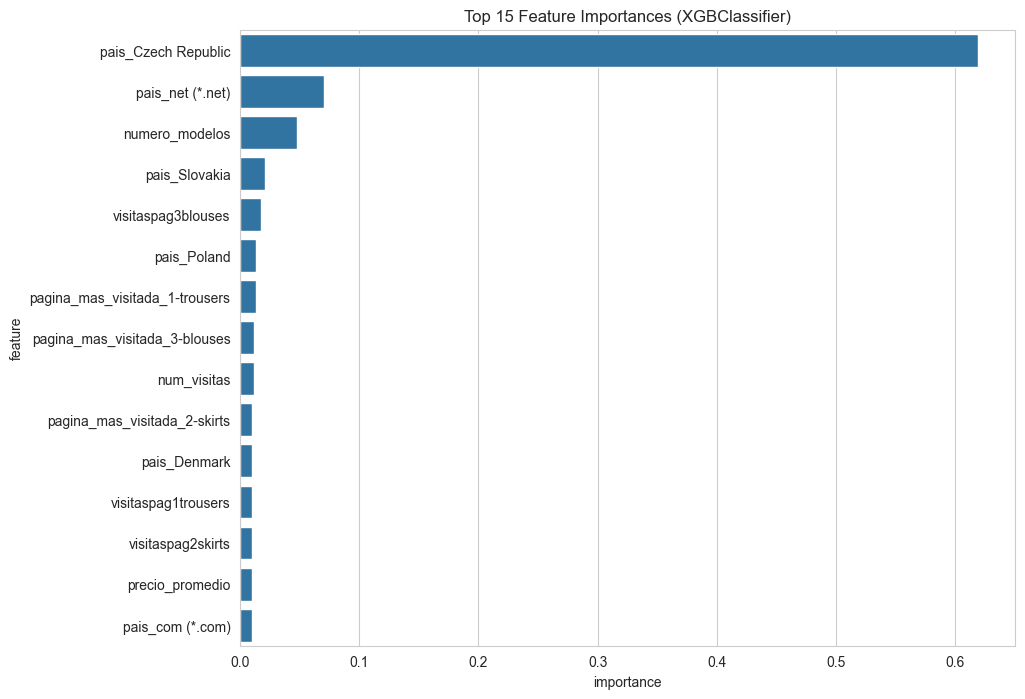

In [70]:
plot_feature_importance(xgb_pipeline)

La variable con la mayor importancia (61%) fue la variable binaria `pais_Czech Republic`, indicando que las sesiones de usuario registradas desde República Checa tienden a registrar compras con más frecuencia.

> Importancia de variables del modelo **LightGBM**

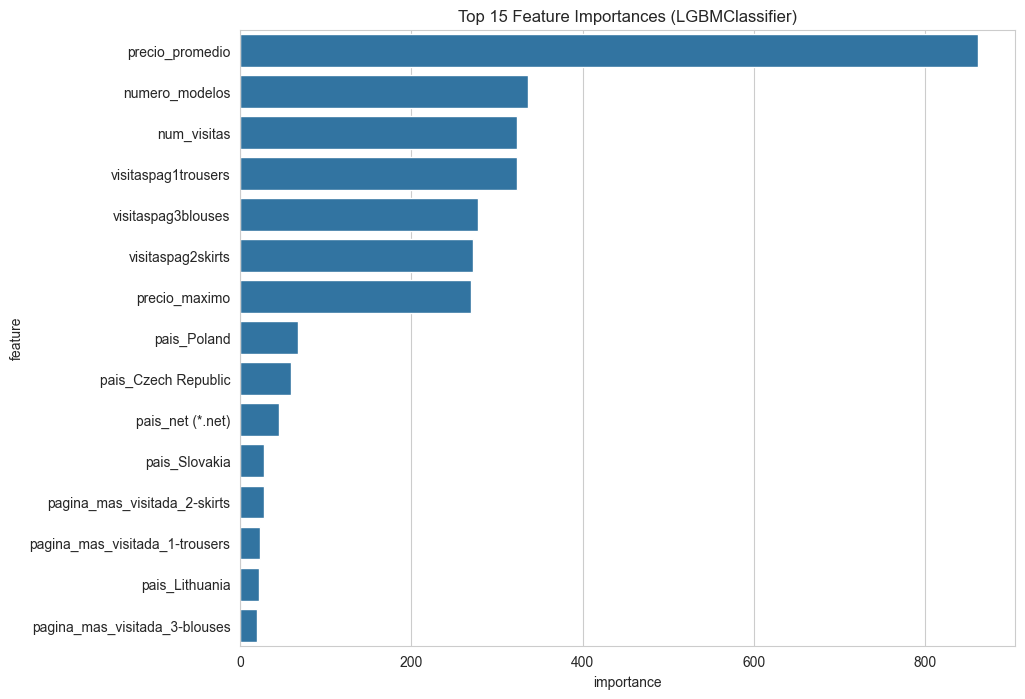

In [71]:
plot_feature_importance(lgbm_pipeline)

> **👨‍🏫👨‍🏫 ¿Cómo se lee la escala del gráfico para el modelo LightGBM?**

Las variables con la mayor importancia fueron: 

- El precio promedio, indicando que a mayor precio promedio de los artículos observados durante la sesión, el usuario tiene mayor probabilidad de realizar una compra.
- El número de modelos, indicando que a mayor número de modelos observados durante la sesión, el usuario tiene mayor probabilidad de realizar una compra.
- El número de visitas, indicando que a cantidad de clicks/visitas a las secciones de la tienda web durante la sesión, el usuario tiene mayor probabilidad de realizar una compra.

# 11. Recomendaciones de negocio

* Analizar a profundidad la presencia en el mercado de República Checa para evaluar si existen buenas prácticas de relacionamiento con los clientes que están acelerando las conversiones.

* Generar avisos automáticos en página web y por correo electrónico para los usuarios sobre promociones en las categorías y modelos de productos que están visitando.

* Aplicar políticas de descuentos para los clientes que realizan compras frecuentes.

* Aplicar políticas de descuentos para los clientes que traen referidos.

* Evaluar la Experiencia de Usuario (UX) para hacer más rápida la experiencia de compra.